# Museums in the Pandemic - Indicator matching validation 
**Authors**: Andrea Ballatore (KCL)

**Abstract**: Validation of matching process of indicators in text.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [46]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [45]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


## Setup spacy NLP

In [3]:
# install language model
!python -m spacy download en_core_web_lg
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |▊                               | 17.0 MB 3.3 MB/s eta 0:03:50^C
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 173, in _main
    status = self.run(options, args)
  File "/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/pip/_internal/resolution/resolvelib/resolver.py", line 75, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/pip/_internal/resolution/resolvelib/f

In [4]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_lg
nlp = en_core_web_lg.load()

In [5]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [6]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

## Annotations

These are manually created annotations (identified by the *example_id*) to identify indicators in the text.

In [7]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,example_id,text_phrases,indicator_code,possible_supercategory,critical_words,valid_annotation
1,ann_ex_00002,closed to members of the public until further ...,closed_cur,NaN,closed further notice,NaN
2,ann_ex_00003,closed until further notice,closed_cur,NaN,closed further notice,NaN
5,ann_ex_00006,currently we are closed due to Covid restricti...,closed_cur,NaN,closed covid,NaN
6,ann_ex_00007,had to close doors,closed_cur,NaN,close doors,NaN
10,ann_ex_00011,there will be no services over due to the Covi...,closed_cur,NaN,no services,NaN
...,...,...,...,...,...,...
273,ann_ex_00274,Our volunteer coordinator will be in touch wit...,staff_working,NaN,in touch,NaN
274,ann_ex_00275,please contact the museum for information,staff_working,NaN,contact museum,NaN
275,ann_ex_00276,If you have any queries please contact,staff_working,NaN,queries contact,NaN
276,ann_ex_00277,We are continuing to work,staff_working,NaN,continuing work,NaN


In [8]:
# this is to debug the token extraction from the annotations.

ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'spacy_extract_tokens' is not defined

## Indicator matching

This code identifies indicators in raw text

In [ ]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [ ]:
print(text_df.columns)
print(ann_df.columns)

In [ ]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

In [ ]:
# a test query to the DB
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

In [ ]:
# get sample of matches museums
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()
df.columns

## Download matches from DB

In [47]:
# dump all matches from DB to a pickle file (SLOW)
sessions = ['20210304'] #,'20210404']
for session_id in sessions:
    get_all_matches_from_db(session_id, db_conn, out_folder)

get_all_matches_from_db 20210304
query results: (1136440, 17)
	saved ../../tmp/matches_dump_df_20210304.pik


## Load matches from pik

`matches_dump_df_v1.pik` is used for Eval data v1, and v2 for Eval data v2 (with critical words).

Eval v3 contains semantic similarity and a better sample.

In [65]:
# select which matches dataset to load

#matches_fn = out_folder+'tmp/matches_dump_df_v1.pik'
#matches_fn = out_folder+'tmp/matches_dump_df_v2.pik'
matches_fn = out_folder+'tmp/matches_dump_df_20210304-v3.pik'
df = pd.read_pickle(matches_fn)
print(df.columns)
df = df.drop_duplicates(subset=['session_id','muse_id','example_id','page_tokens',
        'ann_overlap_criticwords','indicator_code','ann_overlap_tokenlemma','sem_similarity'])
print(df.shape)

Index(['muse_id', 'page_id', 'sentence_id', 'example_id', 'indicator_code',
       'session_id', 'ann_ex_tokens', 'page_tokens', 'sem_similarity',
       'token_n', 'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token',
       'example_len', 'txt_overlap_lemma', 'txt_overlap_token',
       'ann_overlap_criticwords', 'lemmatoken_n', 'ann_overlap_tokenlemma',
       'txt_overlap_tokenlemma', 'indicator_code_closed_indef',
       'indicator_code_closed_perm', 'indicator_code_finance_health',
       'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_made_covid_safe', 'indicator_code_online_engag',
       'indicator_code_online_event', 'indicator_code_online_exhib',
       'indicator_code_open_cafe', 'indicator_code_open_cur',
       'indicator_code_open_onlineshop', 'indicator_code_project_postpone',
       'indicator_code_reope

## Descriptive stats

Describe the full matches dataset from the DB (800K entries for 400 museums).

### Match distributions

In [13]:
# descriptive stats of all values
#df.groupby('keep_stopwords').describe().transpose()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
page_id,889212.0,460833.790326,279330.646375,26.000000,229363.000000,447911.00000,690467.000000,1084312.0
sem_similarity,889212.0,0.704423,0.113949,-0.109400,0.637500,0.71550,0.785300,1.0
token_n,889212.0,0.993193,0.777993,0.000000,1.000000,1.00000,1.000000,13.0
lemma_n,889212.0,1.283595,0.628839,1.000000,1.000000,1.00000,1.000000,13.0
ann_overlap_lemma,889212.0,0.259310,0.149572,0.058820,0.166670,0.23077,0.333330,1.0
ann_overlap_token,889212.0,0.196367,0.170579,0.000000,0.083330,0.16667,0.250000,1.0
example_len,889212.0,5.942764,2.928122,2.000000,4.000000,5.00000,7.000000,17.0
txt_overlap_lemma,889212.0,0.149241,0.102856,0.005650,0.076920,0.12500,0.200000,1.0
txt_overlap_token,889212.0,0.115055,0.111537,0.000000,0.035710,0.09091,0.166670,1.0
ann_overlap_criticwords,889212.0,0.515921,0.174369,0.250000,0.500000,0.50000,0.500000,1.0


### Indicator stats

In [ ]:
# describe indicators
indic_df = round(df['indicator_code'].value_counts(normalize=True)*100,1)
indic_df.columns = ['n_matches']
indic_df.to_csv(out_folder + 'tmp/indicator_stats.csv')
print('N matches =',len(df))
indic_df

In [ ]:
# distribution token_n and lemma_n
print(df[['token_n','lemma_n','lemmatoken_n']].describe().transpose())
df[['token_n','lemma_n','lemmatoken_n']].hist(bins=10)

In [ ]:
# histogram of number of matched lemma/token
df[['lemmatoken_n']].hist(bins=10)

In [ ]:
# exclude matches of a single lemma 
print(df[['lemma_n']][df.lemma_n > 1].describe())
df[['lemma_n']][df.lemma_n > 1].hist(bins=12)

### Overlaps distributions

                           count      mean       std       min       25%  \
ann_overlap_token       926924.0  0.195068  0.170000  0.000000  0.083330   
ann_overlap_lemma       926924.0  0.259498  0.148456  0.058820  0.166670   
ann_overlap_tokenlemma  926924.0  0.260216  0.149524  0.058824  0.166667   

                            50%       75%  max  
ann_overlap_token       0.16667  0.250000  1.0  
ann_overlap_lemma       0.25000  0.333330  1.0  
ann_overlap_tokenlemma  0.25000  0.333333  1.0  


array([[<AxesSubplot:title={'center':'ann_overlap_tokenlemma'}>]],
      dtype=object)

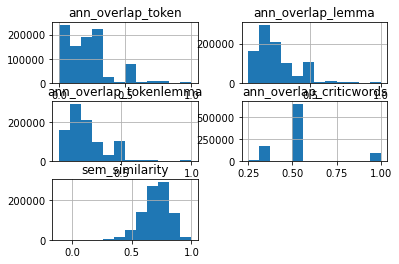

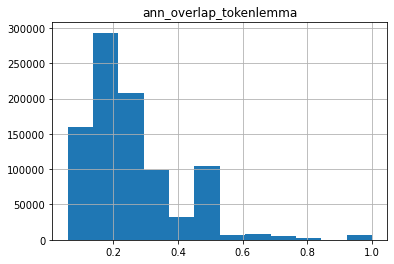

In [66]:
# compare the distributions of the overlap variables between annotations and web pages
print(df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].describe().transpose())
df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma','ann_overlap_criticwords','sem_similarity']].hist(bins=12)

df[['ann_overlap_tokenlemma']].hist(bins=12)

count    926924.000000
mean          5.926285
std           2.919473
min           2.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          17.000000
Name: example_len, dtype: float64
matches with annotations > 1: 926924


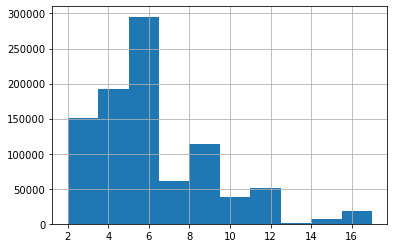

In [67]:
# show length of annotations
print(df['example_len'].describe())
df['example_len'].hist(bins=10)

# filter annotations that are too short: valid df
df = df[df['example_len']>1]
print('matches with annotations > 1:', len(df))

In [68]:
# count number of matches by indicator_code, to see which indicators are more or less popular
indic_df = df[['indicator_code','example_id']].groupby(['indicator_code']).describe()
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                         count unique           top   freq
indicator_code                                            
funding_fundraise       128397     45  ann_ex_00111  12738
lang_difficulty          72410     37  ann_ex_00160   5544
reopen_intent           159688     35  ann_ex_00246  15645
closed_cur              121016     21  ann_ex_00035  10644
online_engag             28642     12  ann_ex_00177   5449
funding_gov_emer         50763     11  ann_ex_00121   6490
staff_working            49126     11  ann_ex_00275  21435
open_onlineshop          51379      9  ann_ex_00205   7060
staff_hiring             16865      8  ann_ex_00263   3958
online_event             38586      8  ann_ex_00180   7302
funding_did_not_get      27046      7  ann_ex_00056   8840
online_exhib             36601      7  ann_ex_00190   8418
finance_health            8005      6  ann_ex_00053   3975
funding_other_emer        8167      4  ann_ex_00126   4598
closed_indef             37087      4  ann_ex_00042  22205
closed_perm              11632      4  ann_ex_00046   6590
reopen_plan              14558      4  ann_ex_00256   6400
open_cur                 42100      3  ann_ex_00198  26266
project_postpone          6416      3  ann_ex_00210   3046
made_covid_safe          11831      1  ann_ex_00167  11831
open_cafe                 6605      1  ann_ex_00195   6605
staff_restruct               4      1  ann_ex_00266      4

## Evaluation of matching method

This is to make sure that matching mechanism identifies matches in museum websites accurately. It uses supervised machine learning.
This dataset is manually annotated by the team. It contains 700 entries of matches that are annotated as valid/not valid.

Notes:
- Manually annotated by AB, AP, PW.
- Two independent annotators for each match.
- Disagreement on 11.5% of cases, manually resolved in discussion with a third independent annotator.
- in ann_ex_tokens, when the word "support" appears it implicitly intends to mean "financial support" whereas in the page_tokens "support" could be mean other types of support as well. Anyway, I marked these as "T" matches. 
- in ann_ex_tokens, phrases such as "currently closed" are implicitly intended to apply to the museum as a whole; whereas the page_tokens seem sometimes to be referreing to closures of parts of the museum, e.g. the grounds, the tea room etc.  I have generally marked these too as "T" matches. 

### Make sample of text matches

Choose sample for manual annotation of matches stratified on overlap bins, to make sure that there is an even distribution. The bins are selected manually based on the distribution, observing high values more in detail than low values (which are almost certainly invalid matches).

In [89]:
# eval v2
if False:
    df['ann_overlap_tokenlemma']
    cut_bins = [0, .25, .5, .6, .7, .8, .9, 1.01]
    df['overlap_bin'] = pd.cut(df['ann_overlap_tokenlemma'], bins=cut_bins)
    df['overlap_bin'].value_counts()
    
# eval v3
if True:
    #print(df['ann_overlap_tokenlemma'].median())
    print(df['ann_overlap_tokenlemma'].quantile([0.,.25,.5,.75,.8,.9]))
    #pd.qcut(df['ann_overlap_tokenlemma'], 5)

    df['sem_similarity'].median()
    pd.qcut(df['sem_similarity'], 5)

    cut_bins = [0, .45, 1.01]
    df['overlap_bin'] = pd.cut(df['ann_overlap_tokenlemma'], bins=cut_bins)
    print(df['overlap_bin'].value_counts())
    
    n = 1000
    df.sample(n).to_excel(out_folder+'tmp/match_sample_for_validation_{}.xlsx'.format(n), index=False)

0.00    0.058824
0.25    0.166667
0.50    0.250000
0.75    0.333333
0.80    0.333333
0.90    0.500000
Name: ann_overlap_tokenlemma, dtype: float64
(0.0, 0.45]     793121
(0.45, 1.01]    133803
Name: overlap_bin, dtype: int64


In [42]:
# Distribution of annotation lengths

# less than 0.2% of cases have annotation length == 1
#(len(df[df.example_len == 1])/len(df))*100

#df = df[df.example_len > 1]
df.example_len.describe()

count    889212.000000
mean          5.942764
std           2.928122
min           2.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          17.000000
Name: example_len, dtype: float64

In [90]:
# generate the stratified sample
sample_df = pd.DataFrame()
sample_n = 400
for bin_name, subdf in df.groupby('overlap_bin'):
    smpl = subdf.sample(sample_n, random_state=1359)
    sample_df = sample_df.append(smpl)
    
print(sample_df['overlap_bin'].value_counts())

sample_df['valid_match'] = ''

# shuffle sample
sample_df = sample_df.sample(frac=1.0)

# generate sample
sample_df.to_excel(out_folder+'tmp/match_sample_for_validation-v3.xlsx', index=False)

sample_df

(0.0, 0.45]     400
(0.45, 1.01]    400
Name: overlap_bin, dtype: int64


,muse_id,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,page_tokens,sem_similarity,token_n,...,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_restruct,indicator_code_staff_working,overlap_bin,valid_match
258241,mm.domus.WA030,202439,mus_page202439_sent00008,ann_ex_00103,funding_fundraise,20210304,make donation,remembering education room hire support us mak...,0.7239,2.0,...,0,0,0,0,0,0,0,0,"(0.45, 1.01]",
24058,mm.domus.SE116,406697,mus_page406697_sent00013,ann_ex_00026,closed_cur,20210304,currently closed government advice,we closed ancient house closed line government...,0.7584,3.0,...,0,0,0,0,0,0,0,0,"(0.45, 1.01]",
72649,mm.wiki.150,507110,mus_page507110_sent00088,ann_ex_00227,reopen_intent,20210304,we look forward seeing again,you can see up date availability book advance ...,0.8023,0.0,...,0,0,0,1,0,0,0,0,"(0.0, 0.45]",
95028,mm.ace.1089,53136,mus_page53136_sent00049,ann_ex_00167,made_covid_safe,20210304,find how we made visit safe,managing ash dieback berrington find how we ta...,0.7761,4.0,...,0,0,0,0,0,0,0,0,"(0.45, 1.01]",
614553,mm.domus.SC261,101660,mus_page101660_sent00008,ann_ex_00101,funding_fundraise,20210304,every donation important us,museum fully accredited member museums galleri...,0.7298,0.0,...,0,0,0,0,0,0,0,0,"(0.0, 0.45]",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880918,mm.domus.YH169,777180,mus_page777180_sent00820,ann_ex_00204,open_onlineshop,20210304,our online shop remains open,online forms achieve,0.7182,1.0,...,0,1,0,0,0,0,0,0,"(0.0, 0.45]",
164614,mm.domus.YH043,853961,mus_page853961_sent00035,ann_ex_00042,closed_indef,20210304,museum closed further notice,elisabeth fraser spencer stanhope last family ...,0.7192,1.0,...,0,0,0,0,0,0,0,0,"(0.0, 0.45]",
730586,mm.domus.WM134,422309,mus_page422309_sent00072,ann_ex_00195,open_cafe,20210304,our cafe open,it so important everyone to fresh air birdsong...,0.7502,1.0,...,0,0,0,0,0,0,0,0,"(0.0, 0.45]",
597829,mm.domus.SE530,329332,mus_page329332_sent00058,ann_ex_00042,closed_indef,20210304,museum closed further notice,read our full access statement pdf monk house ...,0.5644,0.0,...,0,0,0,0,0,0,0,0,"(0.0, 0.45]",


#### Eval data v1

This version has no _critical word_ matches and is based on the match sample v5. Stored in _matches_valid_ann_df_v1.pik_.

In [ ]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
print(len(valid_ann_df))
print(valid_ann_df.columns)

# generate dummy vars
indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
print(valid_ann_df.shape)
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)
print(valid_ann_df.shape)
print(indicator_dummy_vars)
valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})
valid_ann_df['valid_match_b2'] = valid_ann_df['valid_match_2'].map({'T': True, 'F': False})
valid_ann_df.sample(10)

# add extra vars from matches
idx_cols = ['muse_id', 'example_id', 'sentence_id', 'indicator_code']
cols = idx_cols + ['txt_overlap_lemma','txt_overlap_token']
n = len(valid_ann_df)
valid_ann_df = valid_ann_df.merge(df[cols], on=idx_cols)
assert len(valid_ann_df) == n,len(valid_ann_df)

# derived fields
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)

assert valid_ann_df.txt_overlap_tokenlemma.between(0,1).all(),'incorrect range'

valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v1.pik')

#### Eval data v2

This version includes the overlap with critical words (`ann_overlap_criticwords`). It is based on the match sample v5, joined with the full match information.

In [ ]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
orig_valid_ann_df = valid_ann_df
print(len(valid_ann_df))
print(valid_ann_df.columns)
print(len(df))

valid_matches = valid_ann_df[['muse_id','sentence_id','page_tokens','indicator_code',
                              'ann_ex_tokens','valid_match']].drop_duplicates()

all_matches = df

# Note: because IDs example_id mismatch, match rows based on tokens
assert len(all_matches)==881913,len(all_matches)
print(df.columns)

df2 = valid_matches.merge(all_matches, how='left',
            on=['muse_id','sentence_id','ann_ex_tokens','indicator_code','page_tokens']) 

#all_matches
valid_ann_df = df2.drop('example_id',axis=1).drop_duplicates()
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)
n = 700

valid_ann_df = valid_ann_df.sample(n)
valid_ann_df = valid_ann_df[~valid_ann_df.lemma_n.isna()]

valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})

# count invalid matches
#print(valid_ann_df[['ann_ex_tokens','valid_match_b']].value_counts().count())
#print(valid_ann_df[['ann_ex_tokens','valid_match_b']].pivot(index="ann_ex_tokens", columns="valid_match_b"))

indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)

#del all_matches, valid_matches
print(len(valid_ann_df))
print(valid_ann_df.columns)
valid_ann_df.to_excel(out_folder+'tmp/match_sample_for_validation-v6.xlsx', index=False)

del df2

In [ ]:
# convert validation annotations to pikle
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v6.xlsx')
print(len(valid_ann_df))
valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v2.pik')
valid_ann_df.sample(5)

#### Eval data v3

This version includes semantic similarity (19 Oct 2021).

In [ ]:
TODO

### Simple threshold method

This is a matching method that uses only a threshold of `ann_overlap_tokenlemma` to select valid matches. It gives ok results, but not comparable to the other methods. Best result: accuracy .84, false positives 13%.

In [ ]:
# observe distribution of value
len(valid_ann_df)
print(valid_ann_df.ann_overlap_tokenlemma.describe())

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# test precision_recall_fscore_support function
precision_recall_fscore_support([True, False, True, False], [True, False, True, True], average='binary')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

thdf = valid_ann_df.copy()

resdf = pd.DataFrame()

# loop through thresholds
for th in arange(.2,1.001,.05):
    print("---\nKeeping values ann_overlap_tokenlemma above: ",th)
    # PICK A VARIABLE
    thdf['predicted'] = thdf.ann_overlap_tokenlemma >= th
    #thdf['predicted'] = thdf.ann_overlap_criticwords >= th
    
    precision, recall, fscore, support = precision_recall_fscore_support(thdf.valid_match_b, thdf.predicted, average='binary')
    print(thdf.predicted.value_counts())
    stats = classification_report(thdf.valid_match_b, thdf.predicted)

    # confusion matrix
    confmat = confusion_matrix(thdf.valid_match_b, thdf.predicted, normalize='all')
    tn, fp, fn, tp = confmat.ravel()
    print('false positives %:',round(fp*100,1))

    subdf = pd.DataFrame.from_dict({'threshold':[th], 'precision':[round(precision,3)], 'recall':[round(recall,3)], 
            'fscore':[round(fscore,3)], 
            'accuracy': round(accuracy_score(thdf.valid_match_b, thdf.predicted),3),
            'false_positives': round(fp,3)})
    del tn, fp, fn, tp
    resdf = pd.concat([resdf, subdf])

resdf = resdf.reset_index()
resdf

In [ ]:
import seaborn as sns
p = sns.lineplot(data=resdf, x="threshold", y="accuracy", label='accuracy')
p = sns.lineplot(data=resdf, x="threshold", y="precision", label='precision')
p = sns.lineplot(data=resdf, x="threshold", y="recall", label='recall')
p = sns.lineplot(data=resdf, x="threshold", y="fscore", label='fscore')
p = sns.lineplot(data=resdf, x="threshold", y="false_positives", label='false_pos')
p.set(ylim=(0,1))
p.legend()

Show mean values by indicator code.

In [ ]:
valid_ann_df.groupby('indicator_code').mean()

Show mean values by valid/not valid matches.

In [ ]:
valid_ann_df.groupby('valid_match_b').mean()

### Run traditional models

Compare traditional classifiers, e.g. SVM, Logistic Regression, and generate the evaluation results in a data frame. Compare binary classifier to determine whether a match between an annotation and a sentence in a museum website is valid or not.

- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.analyticsvidhya.com/blog/2021/04/beginners-guide-to-logistic-regression-using-python/

In [ ]:
# load ML packages
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def run_traditional_model(num_df, valid_ann_df_fn, var_group, test_size, clf):
    print('run_traditional_model', i, valid_ann_df_fn, len(var_group), test_size, clf)
    # prep data
    y_data = num_df['valid_match_b']
    x_data = num_df.drop('valid_match_b', axis = 1)
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = test_size, random_state=2)

    # Train the model and create predictions
    clf.fit(x_training_data, y_training_data)
    predictions = clf.predict(x_test_data)

    # confusion matrix
    confmat = confusion_matrix(y_test_data, predictions, normalize='all')
    tn, fp, fn, tp = confmat.ravel()

    # evaluation metrics
    precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, predictions, average='binary')
    acc = accuracy_score(y_test_data, predictions)
    del x_training_data, x_test_data, y_training_data, y_test_data

    # cross-validation
    crossval_predicted = cross_val_predict(clf, x_data, y_data, cv=6)
    crossval_acc = round(accuracy_score(y_data, crossval_predicted),2)
    del crossval_predicted

    # pack results
    subdf = pd.DataFrame.from_dict({
        'trial_i': i,
        'eval_file': valid_ann_df_fn,
        'var_group':' '.join(var_group),
        'model':str(clf), 'test_size':test_size, 'x_shape':str(x_data.shape),
        'accuracy': round(acc,2),
        'precision':[round(precision,3)], 'recall':[round(recall,3)], 
        'fscore':[round(fscore,3)], 
        'crossval_acc': crossval_acc,
        'false_pos': round(fp,2),'false_neg': round(fn,2)})
    return subdf

# prep variables
eval_dfs = [ 'matches_valid_ann_df_v2.pik']

in_var_groups = [
    #['txt_overlap_tokenlemma'],
    #['ann_overlap_tokenlemma'],
    #['ann_overlap_criticwords'],
    #['txt_overlap_token','txt_overlap_lemma','ann_overlap_criticwords'],
    #['txt_overlap_token','ann_overlap_criticwords','example_len'],
    ['lemmatoken_n','txt_overlap_token','ann_overlap_criticwords','example_len'],
    ['lemmatoken_n','ann_overlap_tokenlemma','txt_overlap_lemma','example_len'],
]

var_groups = []
for x in in_var_groups: 
    x1 = x.copy()
    x1.extend(indicator_dummy_vars.tolist()) 
    x.append('valid_match_b')
    x1.append('valid_match_b')
    var_groups.append(x)
    var_groups.append(x1)
    
# iterate over models
models = [
    #LogisticRegression(random_state=0),
    #svm.SVC(random_state=0),
    #MLPClassifier(random_state=1),
    #GaussianNB(),
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5)
]

for i in [5,10,20]:
    models.append(RandomForestClassifier(max_depth=i)) # random_state=10

split_sizes = [.3,.4,.5]
repeat_trials = 10

resdf = pd.DataFrame()
assert len(models) > 0

# generate all results (SLOW)
for valid_ann_df_fn in eval_dfs:
    # load validation dataset
    print(40*'-')
    print(valid_ann_df_fn)
    valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)
    
    for var_group in var_groups:
        # extract numeric matrix
        #if not pd.Series(var_group).isin(valid_ann_df.columns).all():
        # skip
        #    continue
        print(valid_ann_df.columns)
        print(var_group)
        num_df = valid_ann_df[var_group]
        # loop through test sizes
        for test_size in split_sizes:
            # loop through models
            for clf in models:
                # repeat trial N times
                for i in range(repeat_trials):
                    subdf = run_traditional_model(num_df, valid_ann_df_fn, var_group, test_size, clf)
                    subdf['trial_i'] = i
                    resdf = pd.concat([resdf, subdf])
        del num_df
    del valid_ann_df

resdf = resdf.sort_values(by='accuracy', ascending=False)
resdf.to_excel(out_folder+'tmp/match_validation_comparison_traditional_models.xlsx', index=False)
resdf

### Feature selection

Quantify contribution of each variable in the matching process using recursive feature elimination (RFE).

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

def backward_elimination():
    """ TODO """
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    print(selected_features_BE)
    return selected_features_BE

eval_dfs = ['matches_valid_ann_df_v2.pik']

for valid_ann_df_fn in eval_dfs:
    # load validation dataset
    print(40*'-')
    print(valid_ann_df_fn)
    valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)
    x_data = valid_ann_df.select_dtypes(include=[np.number])
    x_data = x_data.drop(['ann_overlap_tokenlemma','txt_overlap_tokenlemma'], axis = 1)
    print(len(valid_ann_df))
    y_data = valid_ann_df['valid_match_b']

    if False:
        # create pipeline with stratified K fold
        model = RandomForestClassifier(max_depth=5, random_state=10)
        model_est = RandomForestClassifier(max_depth=5, random_state=10)
        rfe = RFE(estimator=model_est, n_features_to_select=5)
        pipeline = Pipeline(steps=[('s',rfe),('m',model)])
        # evaluate model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)
        n_scores = cross_val_score(pipeline, x_data, y_data, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        # report performance
        print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    if True:
        estimator = RandomForestClassifier(max_depth=5, random_state=10)
        # Recursive Feature Elimination (RFE)
        selector = RFE(estimator, n_features_to_select=5, step=1)
        selector = selector.fit(x_data, y_data)
        print(selector.support_)
        print(selector.ranking_)
        from operator import itemgetter
        features = x_data.columns.to_list()
        for x, y in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
            print(x, y)

### Deep Learning

Find valid matches using deep learning and `keras`.

- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras
- https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.metrics import FalsePositives, BinaryAccuracy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from numpy import mean
from numpy import std

# https://stackoverflow.com/questions/48285129/saving-best-model-in-keras/48286003
early_stopping_monitor = EarlyStopping(
    monitor='binary_accuracy',
    min_delta=0,
    patience=150,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

def build_convolutional_nn(input_dim, neurons):
    print('build_convolutional_nn: ', input_dim, neurons)
    model = Sequential()
    # add first layer
    model.add(Dense(neurons[0], input_dim=input_dim, activation='relu'))
    # add intermediate layers
    for neur in neurons[1:]:
        model.add(Dense(neur, activation='relu'))
    # add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
    return model


def run_deep_learning(df, test_size, neurons, batch_size, early_stopping_monitor=early_stopping_monitor):
    """ create and call a Keras model with layers """
    print('run_deep_learning', df.shape, test_size, neurons, batch_size)
    # get only numeric columns
    x_data = df.select_dtypes(include=[np.number])
    if True:
        # create scaler
        scaler = MinMaxScaler()
        # fit and transform in one step
        cols = x_data.columns
        x_data = pd.DataFrame(scaler.fit_transform(x_data),columns=cols)
    
    y_data = df[['valid_match_b']]
    # train/test split
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = test_size)
    #print('train/test',x_training_data.shape, x_test_data.shape, y_training_data.shape, y_test_data.shape)

    # define the keras model
    model = build_convolutional_nn(len(x_data.columns), neurons)
    
    if True:
        # fit model
        # https://keras.io/guides/training_with_built_in_methods/
        history = model.fit(x_training_data, y_training_data, epochs=150, batch_size=batch_size, verbose=0,
                           callbacks=[early_stopping_monitor]) # , validation_split=test_size
        # plot metrics
        #pyplot.plot(history.history['binary_accuracy'])
        #pyplot.show()
        # evaluate model
        loss, accuracy = model.evaluate(x_test_data, y_test_data, verbose=0)
        print("-> acc ",accuracy)
        # get predicted values
        pred_y = (model.predict(x_test_data) > 0.5).astype("bool")
        # unpack results
        pred_y = [item for sublist in pred_y for item in sublist]
        # calculate IR metrics
        precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, pred_y, average='binary')        
        # calculate confusion matrix
        confmat = confusion_matrix(y_test_data, pred_y, normalize='all')
        tn, fp, fn, tp = confmat.ravel()
        del pred_y
        # save results
        res_d = {
            'neurons': [str(neurons)],
            'batch_size': [batch_size],
            'test_size_split': [test_size],
            'x_shape': [str(x_data.shape)],
            'accuracy': [round(accuracy,3)],
            'precision': [round(precision,3)],
            'recall': [round(recall,3)],
            'fscore': [round(fscore,3)],
            'false_pos': [round(fp,3)],
            'false_neg': [round(fn,3)],
            'loss': [round(loss,3)],
            'accuracy_train_max': [round(max(history.history['binary_accuracy']),3)]
        }
        del tn, fp, fn, tp
        return res_d, model

    if False:
        # cross validation
        #estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5, verbose=0)
        #kfold = StratifiedKFold(n_splits=10, shuffle=True)
        #results = cross_val_score(estimator, x_data, y_data, cv=kfold)
        #print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        estimators = []
        estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', KerasClassifier(build_fn=model, epochs=100, batch_size=5, verbose=0)))
        pipeline = Pipeline(estimators)
        kfold = StratifiedKFold(n_splits=10, shuffle=True)
        results = cross_val_score(pipeline, x_data, y_data, cv=kfold)
        print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# set input for deep learning        
valid_ann_df_fn = 'matches_valid_ann_df_v2.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

neuron_blocks = [
    [8],
    [8,16],
    #[32,32],
    #[8,16,32],
    #[256,512],
    #[32,64,512]
]
n_trials = 10
test_split_sizes = [.4] # [.4]
batch_sizes = [8] #[1,8,32]

# loop over parameters
resdf = pd.DataFrame()

for batch_size in batch_sizes:
    for test_size in test_split_sizes:
        for neur in neuron_blocks:
            print("-"*40)
            for i in range(n_trials):
                res_d, _ = run_deep_learning(valid_ann_df, test_size, neur, batch_size)
                df = pd.DataFrame.from_dict(res_d)
                df['trial'] = i
                resdf = pd.concat([resdf, df])
                del df
            
resdf = resdf.reset_index()
resdf.to_excel(out_folder+'tmp/match_validation_model_comparison_deeplearning.xlsx', index=False)

del valid_ann_df, test_split_sizes, neuron_blocks, n_trials, valid_ann_df_fn

resdf

### Summarise trials

- The best of traditional models overall is RandomForestClassifier(max_depth=10), similar to depth 20. Average accuracy .83 +- .03.

In [ ]:
# summary of trials
fn = out_folder+'data/analysis/matching_validation/match_validation_comparison_traditional_models-v1.xlsx'
resdf = pd.read_excel(fn)
resdf = resdf.sort_values(['accuracy'], ascending=False)
resdf

In [ ]:
desc_df = resdf[['model','accuracy','false_pos']].groupby(['model']).mean()
#desc_df = desc_df.sort_values(('accuracy'), ascending=False)
desc_df

Summarise best random forest trials to check for model stability.

In [ ]:
fn = out_folder+'data/analysis/matching_validation/match_validation_comparison_traditional_models_top_randomforests-v1.xlsx'
resdf = pd.read_excel(fn)
print(resdf.columns)
resdf

#### Best random forest model 

The best Random Forest reaches 

- accuracy .867 +- .01.
- precision .91
- recall .90
- fscore .89
- false_pos .06
- false_neg .08



In [ ]:
# summary of best random forest
resdf = resdf[(resdf.model == 'RandomForestClassifier(max_depth=20)') & (resdf.x_shape=='(700, 23)')]
desc_df = resdf[['model','accuracy','precision','fscore','recall','var_group','false_pos','false_neg']].groupby(['model','var_group']).mean()
#desc_df = des.model == 'RandomForestClassifier(max_depth=10)'c_df.sort_values(('accuracy'), ascending=False)
desc_df.iloc[1].round(2)
desc_df

#### Best deep learning model

Best model has neurons: [8,16]; batch size: 8; split .3.

- accuracy              0.893 +- 0.01
- precision             0.900
- recall                0.932
- fscore                0.916
- false_pos             0.064
- false_neg             0.042

Overall, this is the **best model**, slightly better than the random forests (higher accuracy but mostly higher recall and lower false negatives, 4% vs 8%).

In [ ]:
fn = out_folder+'data/analysis/matching_validation/match_validation_model_comparison_deeplearning-v2.xlsx'
resdf = pd.read_excel(fn)
resdf.head(5)

In [ ]:
resdf.groupby(['neurons','batch_size','test_size_split']).mean().sort_values('accuracy').tail(3)

In [ ]:
best_dl = resdf[(resdf.neurons=='[8, 16]') & (resdf.batch_size==8) & (resdf.test_size_split==.3) ]
best_dl.mean().round(3)

In [ ]:
best_dl.std().round(3)

In [ ]:
resdf.groupby('batch_size').mean().round(3)

In [ ]:
resdf.groupby('neurons').mean().round(3)

## Run deep learning on all museums

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

### Build best DL model

{'neurons': ['[8, 16]'],
 'batch_size': [8],
 'test_size_split': [0.3],
 'x_shape': ['(700, 30)'],
 'accuracy': [0.919],
 'precision': [0.938],
 'recall': [0.931],
 'fscore': [0.934],
 'false_pos': [0.038],
 'false_neg': [0.043],
 'loss': [0.298],
 'accuracy_train_max': [0.922]}

In [ ]:
# build best model: neurons: [8,16]; batch size: 8; split .3.

# call model fit with callbacks=[early_stopping_monitor]

valid_ann_df_fn = 'matches_valid_ann_df_v2.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

old_acc = 0
eval_stats = None
for i in range(20):
    print("-"*30)
    eval_df, model = run_deep_learning(valid_ann_df, .3, [8,16], 8, early_stopping_monitor)
    acc = eval_df['precision'][0]
    print('accuracy', acc)
    if old_acc < acc:
        fn = out_folder+'tmp/matching_validation_deep_learning_model.h5'
        model.save(fn)
        print('saved in',fn)
        eval_stats = eval_df
        old_acc = acc

print('best model')
eval_stats

End of notebook